In [1]:
# Verificar entorno
import sys
print("Python version:", sys.version)

# Importar librer√≠as esenciales
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
TensorFlow version: 2.19.0
GPU disponible: []


In [2]:
# Descargar e importar el dataset
import tensorflow_datasets as tfds

# Cargar el dataset (se descargar√° autom√°ticamente si no est√° en cache)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Informaci√≥n del dataset
num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names
print(f"N√∫mero de clases: {num_classes}")
print(f"Nombres de clases: {class_names}")

# Tama√±o del dataset
print(f"Entrenamiento: {len(ds_train)} im√°genes")
print(f"Validaci√≥n: {len(ds_val)} im√°genes")
print(f"Prueba: {len(ds_test)} im√°genes")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.H7A22C_3.0.1/tf_flowers-train.tfrecord*...:   0%|   ‚Ä¶

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
N√∫mero de clases: 5
Nombres de clases: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
Entrenamiento: 2569 im√°genes
Validaci√≥n: 551 im√°genes
Prueba: 550 im√°genes


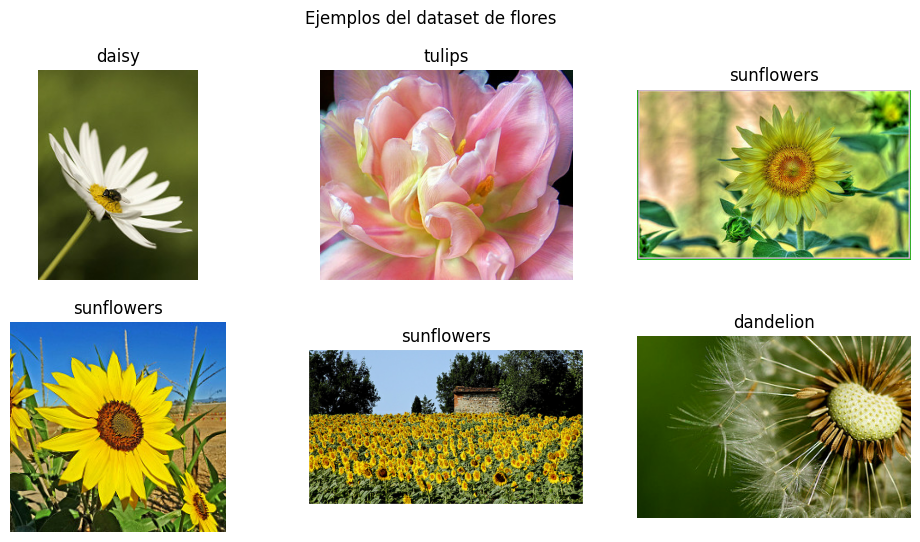

In [3]:
plt.figure(figsize=(12, 6))
for i, (image, label) in enumerate(ds_train.take(6)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")
plt.suptitle("Ejemplos del dataset de flores")
plt.show()

In [4]:
# Tama√±o de entrada para EfficientNetB0
IMG_SIZE = 224
BATCH_SIZE = 32

# Funci√≥n de preprocesamiento
def preprocess_image(image, label):
    # Redimensionar imagen
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Convertir a float32
    image = tf.cast(image, tf.float32)
    # No normalizamos aqu√≠ porque EfficientNet incluye su propio preprocesamiento
    return image, label

# Aplicar preprocesamiento y crear lotes
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Configurar rendimiento
ds_train = ds_train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [5]:
# Cargar EfficientNetB0 sin la capa final (include_top=False)
base_model = keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelar las capas del modelo base
base_model.trainable = False

# Construir el modelo completo
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')  # 5 clases
])

# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar resumen del modelo
model.summary()

16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step


Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ efficientnetb0 (Functional)     ‚îÇ (None, 7, 7, 1280)     ‚îÇ     4,049,571 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_average_pooling2d        ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îÇ (GlobalAveragePooling2D)        ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)               ‚îÇ (None, 1280)           ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                   ‚îÇ (None, 128)            ‚îÇ       163,968 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)             ‚îÇ (None, 128)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                 ‚îÇ (None, 5)              ‚îÇ           645 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entrenamiento
EPOCHS = 15
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 262s 3s/step - accuracy: 0.7015 - loss: 0.8059 - val_accuracy: 0.9129 - val_loss: 0.2556
Epoch 2/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 242s 3s/step - accuracy: 0.9082 - loss: 0.2630 - val_accuracy: 0.9183 - val_loss: 0.2175
Epoch 3/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 225s 3s/step - accuracy: 0.9444 - loss: 0.1914 - val_accuracy: 0.9347 - val_loss: 0.1998
Epoch 4/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 276s 3s/step - accuracy: 0.9510 - loss: 0.1474 - val_accuracy: 0.9220 - val_loss: 0.2101
Epoch 5/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 233s 3s/step - accuracy: 0.9710 - loss: 0.1100 - val_accuracy: 0.9274 - val_loss: 0.1896
Epoch 6/15
81/81 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 228s 3s/step - accuracy: 0.9579 - loss: 0.1224 - val_accuracy: 0.9328 - val_loss: 0.185

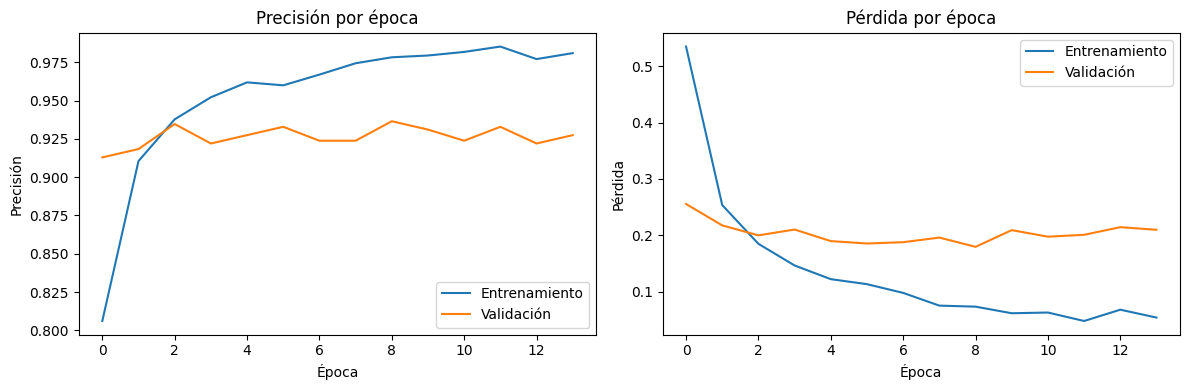

In [7]:
# Extraer m√©tricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='Validaci√≥n')
plt.legend(loc='lower right')
plt.title('Precisi√≥n por √©poca')
plt.xlabel('√âpoca')
plt.ylabel('Precisi√≥n')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='Validaci√≥n')
plt.legend(loc='upper right')
plt.title('P√©rdida por √©poca')
plt.xlabel('√âpoca')
plt.ylabel('P√©rdida')

plt.tight_layout()
plt.show()

In [8]:
test_loss, test_accuracy = model.evaluate(ds_test, verbose=0)
print(f"\nüîç Precisi√≥n en prueba: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


üîç Precisi√≥n en prueba: 0.9455 (94.55%)


1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 6s/step


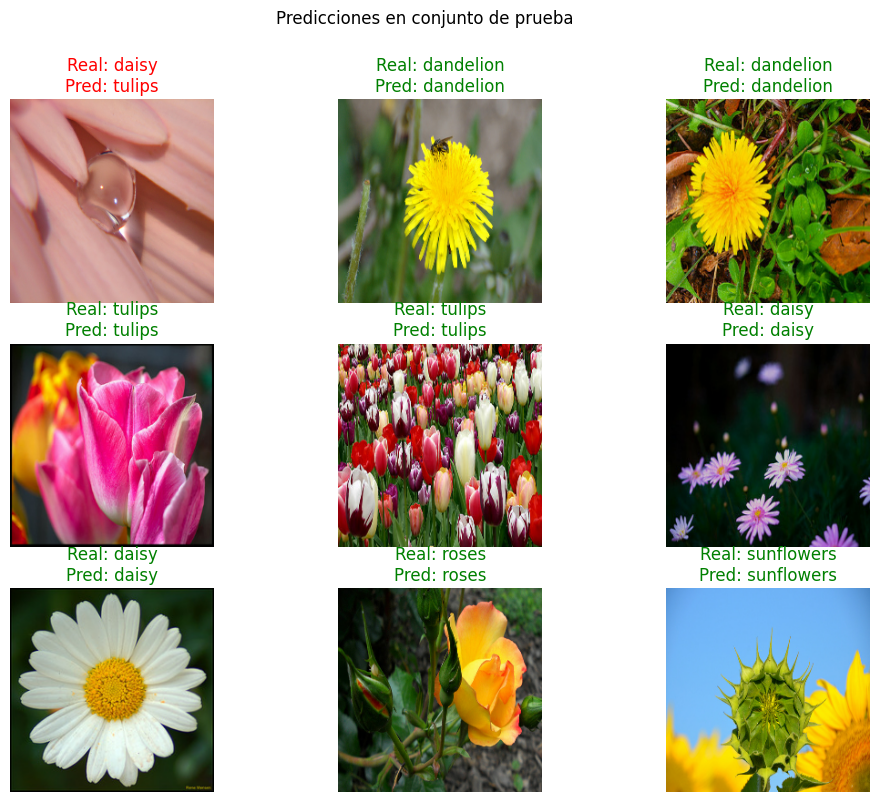

In [9]:
# Obtener un lote de prueba
images, labels = next(iter(ds_test))
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Mostrar 9 predicciones
plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    true_label = class_names[labels[i]]
    pred_label = class_names[predicted_classes[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"Real: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")
plt.suptitle("Predicciones en conjunto de prueba")
plt.show()

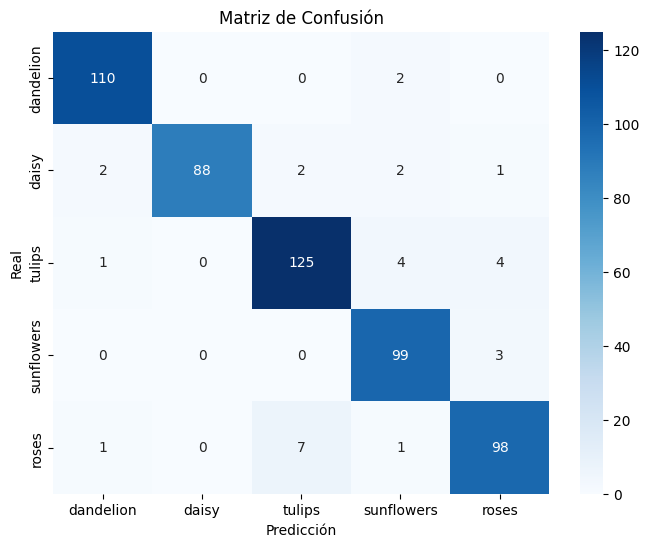


üìã Reporte de clasificaci√≥n:
              precision    recall  f1-score   support

   dandelion       0.96      0.98      0.97       112
       daisy       1.00      0.93      0.96        95
      tulips       0.93      0.93      0.93       134
  sunflowers       0.92      0.97      0.94       102
       roses       0.92      0.92      0.92       107

    accuracy                           0.95       550
   macro avg       0.95      0.95      0.95       550
weighted avg       0.95      0.95      0.95       550



In [10]:
# Obtener todas las etiquetas y predicciones del conjunto de prueba
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Calcular matriz de confusi√≥n
cm = confusion_matrix(y_true, y_pred)

# Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusi√≥n')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()

# Reporte de clasificaci√≥n
print("\nüìã Reporte de clasificaci√≥n:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [11]:

analisis = """
‚úÖ ¬øPor qu√© se eligi√≥ EfficientNetB0?
- EfficientNetB0 ofrece un excelente equilibrio entre precisi√≥n y eficiencia computacional.
- Tiene menos par√°metros que ResNet50, lo que reduce el riesgo de sobreajuste en datasets peque√±os como tf_flowers (~3.6k im√°genes).
- Est√° preentrenado en ImageNet, lo que permite transferir conocimiento visual relevante incluso con pocos datos.

‚ö†Ô∏è ¬øCu√°les fueron los principales desaf√≠os?
1. **Desbalance de clases**: Algunas flores (como girasoles) tienen muchas m√°s im√°genes que otras (como tulipanes), lo que puede sesgar el modelo.
2. **Variabilidad visual**: Las im√°genes tienen fondos no controlados, iluminaci√≥n variable y √°ngulos diversos.
3. **Tama√±o limitado del dataset**: Con solo unas pocas miles de im√°genes, el modelo puede tener dificultades para generalizar a flores no vistas.

üöÄ ¬øQu√© mejorar√≠as para producci√≥n?
- **Aumento de datos**: Aplicar transformaciones (rotaci√≥n, zoom, volteo) para enriquecer el conjunto de entrenamiento.
- **Fine-tuning**: Descongelar las √∫ltimas capas de EfficientNetB0 y reentrenar con una tasa de aprendizaje baja (ej. 1e-5).
- **Balanceo de clases**: Usar `class_weight='balanced'` en `model.fit()` o t√©cnicas de sobremuestreo.
- **Validaci√≥n m√°s robusta**: Implementar validaci√≥n cruzada estratificada.
- **Exportaci√≥n para dispositivos**: Convertir el modelo a TensorFlow Lite para uso en m√≥viles o edge devices.
- **Monitoreo en producci√≥n**: Registrar m√©tricas de inferencia y reentrenar peri√≥dicamente con nuevos datos.
"""

print(analisis)


‚úÖ ¬øPor qu√© se eligi√≥ EfficientNetB0?
- EfficientNetB0 ofrece un excelente equilibrio entre precisi√≥n y eficiencia computacional.
- Tiene menos par√°metros que ResNet50, lo que reduce el riesgo de sobreajuste en datasets peque√±os como tf_flowers (~3.6k im√°genes).
- Est√° preentrenado en ImageNet, lo que permite transferir conocimiento visual relevante incluso con pocos datos.

‚ö†Ô∏è ¬øCu√°les fueron los principales desaf√≠os?
1. **Desbalance de clases**: Algunas flores (como girasoles) tienen muchas m√°s im√°genes que otras (como tulipanes), lo que puede sesgar el modelo.
2. **Variabilidad visual**: Las im√°genes tienen fondos no controlados, iluminaci√≥n variable y √°ngulos diversos.
3. **Tama√±o limitado del dataset**: Con solo unas pocas miles de im√°genes, el modelo puede tener dificultades para generalizar a flores no vistas.

üöÄ ¬øQu√© mejorar√≠as para producci√≥n?
- **Aumento de datos**: Aplicar transformaciones (rotaci√≥n, zoom, volteo) para enriquecer el conjunto de

In [12]:
# Guardar el modelo entrenado
model.save("efficientnet_flowers.h5")
print("‚úÖ Modelo guardado como 'efficientnet_flowers.h5'")

‚úÖ Modelo guardado como 'efficientnet_flowers.h5'
